In [1]:
# import all necessery library

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from model import CNN_model

### Reading CIFAR 10 data set & augmentation

In [3]:
# Finding mean & stdv of CIFAR10 dataset

CIFAR_train = torchvision.datasets.CIFAR10(root='./data', train=True,download=True)
CIFAR_test = torchvision.datasets.CIFAR10(root='./data', train=False,download=True)


data = CIFAR_train.data / 255 # data is numpy array
mean = data.mean(axis = (0,1,2))
std = data.std(axis = (0,1,2))
print(f"Mean : {mean} ,STD: {std} ")
print(f"No. of classes :{CIFAR_train.classes}")
print(f"No. of images in train :{len(CIFAR_train)} , test : {len(CIFAR_test)}")
x = np.asarray(CIFAR_train[1][0])
print(f"Images size : {x.shape}")


Files already downloaded and verified
Files already downloaded and verified
Mean : [0.49139968 0.48215841 0.44653091] ,STD: [0.24703223 0.24348513 0.26158784] 
No. of classes :['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
No. of images in train :50000 , test : 10000
Images size : (32, 32, 3)


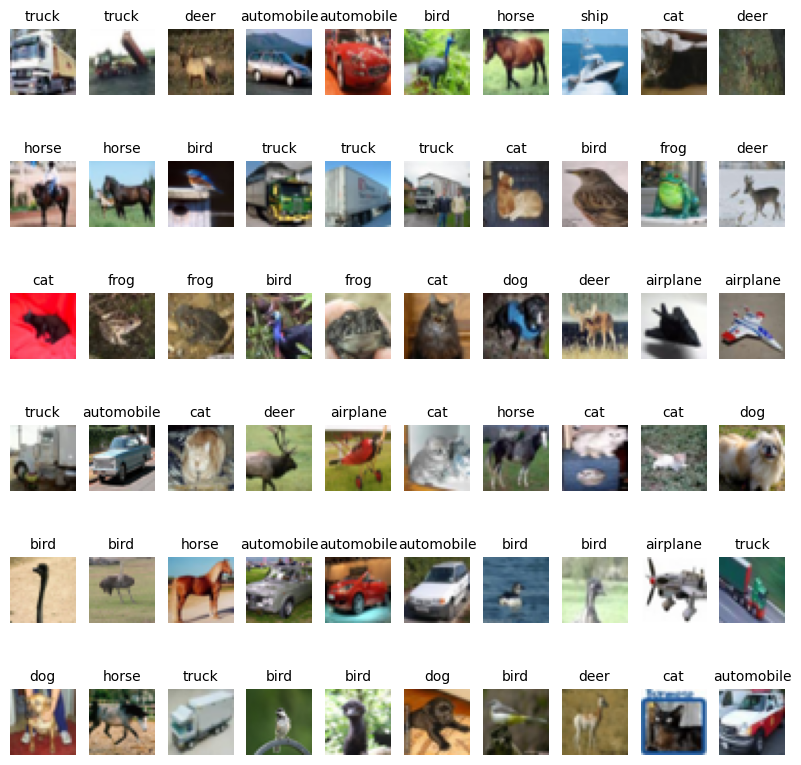

In [4]:
# Plotting the images of CIFAR10

%matplotlib inline
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10,10))
num_of_images = 60

for i in range(1,num_of_images+1):

  plt.subplot(6, 10, i)
  plt.axis('off')
  plt.title(CIFAR_train.classes[CIFAR_train[i][1]],fontsize=10)
  plt.imshow(np.asarray(CIFAR_train[i][0]), cmap='gray_r')


In [5]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,1,1)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215841, 0.44653091),(0.24703223, 0.24348513, 0.26158784)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215841, 0.44653091),(0.24703223, 0.24348513, 0.26158784))
                                       ])

In [6]:
# Download data and apply transformation

train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Data loader arguments

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


### Model Summary

In [8]:
# Batch normalization summary

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = CNN_model('BN').to(device)
print("Batch Normalization Model")
summary(model, input_size=(3, 32, 32))

Batch Normalization Model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
              ReLU-2            [-1, 8, 32, 32]               0
       BatchNorm2d-3            [-1, 8, 32, 32]              16
           Dropout-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,152
              ReLU-6           [-1, 16, 32, 32]               0
       BatchNorm2d-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9            [-1, 8, 34, 34]             128
        MaxPool2d-10            [-1, 8, 17, 17]               0
           Conv2d-11           [-1, 16, 17, 17]           1,152
             ReLU-12           [-1, 16, 17, 17]               0
      BatchNorm2d-13           [-1, 16, 17, 17]              32
          Dro

In [9]:
# Layer normalization summary

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = CNN_model('LN').to(device)
print("Layer Normalization Model")
summary(model, input_size=(3, 32, 32))

Layer Normalization Model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
              ReLU-2            [-1, 8, 32, 32]               0
         GroupNorm-3            [-1, 8, 32, 32]              16
           Dropout-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,152
              ReLU-6           [-1, 16, 32, 32]               0
         GroupNorm-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9            [-1, 8, 34, 34]             128
        MaxPool2d-10            [-1, 8, 17, 17]               0
           Conv2d-11           [-1, 16, 17, 17]           1,152
             ReLU-12           [-1, 16, 17, 17]               0
        GroupNorm-13           [-1, 16, 17, 17]              32
          Dro

In [10]:
# Group normalization summary

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = CNN_model('GN').to(device)
print("Group Normalization Model")
summary(model, input_size=(3, 32, 32))

Group Normalization Model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
              ReLU-2            [-1, 8, 32, 32]               0
         GroupNorm-3            [-1, 8, 32, 32]              16
           Dropout-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,152
              ReLU-6           [-1, 16, 32, 32]               0
         GroupNorm-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9            [-1, 8, 34, 34]             128
        MaxPool2d-10            [-1, 8, 17, 17]               0
           Conv2d-11           [-1, 16, 17, 17]           1,152
             ReLU-12           [-1, 16, 17, 17]               0
        GroupNorm-13           [-1, 16, 17, 17]              32
          Dro

### Training and Validation

In [11]:
test_losses = []
test_acc = []
train_acc = []
train_losses = []

def train(model, device, train_loader, optimizer, epoch):


    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        #print(y_pred.shape)
        #print(target.shape)
        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
    
    return train_acc,train_losses
  

def test(model, device, test_loader):


    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_acc,test_losses


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='whitegrid')

# Increase the plot size and font size.
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = (25,6)

# Plot the learning curve.
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(np.array(BN_train_loss), 'red', label="BN + L1 Training Loss")
ax1.plot(np.array(GN_train_loss), 'green', label="GN Training Loss")
ax1.plot(np.array(LN_train_loss), 'yellow', label="LN Training Loss")
ax1.plot(np.array(BN_test_loss), 'blue', label="BN + L1 Test Loss")
ax1.plot(np.array(GN_test_loss), 'black', label="GN Test Loss")
ax1.plot(np.array(LN_test_loss), 'purple', label="LN Test Loss")

# Label the plot.
ax1.set_title("Training & Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_ylim(0,0.2)
ax1.legend()

ax2.plot(np.array(BN_train_acc), 'red', label="BN + L1 Training Accuracy")
ax2.plot(np.array(GN_train_acc), 'green', label="GN Training Accuracy")
ax2.plot(np.array(LN_train_acc), 'yellow', label="LN Training Accuracy")
ax2.plot(np.array(BN_test_acc), 'blue', label="BN + L1 Test Accuracy")
ax2.plot(np.array(GN_test_acc), 'black', label="GN Test Accuracy")
ax2.plot(np.array(LN_test_acc), 'purple', label="LN Test Accuracy")

# Label the plot.
ax2.set_title("Training & Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_ylim(95,100)
ax2.legend()

plt.show()

In [ ]:
def misclassification(predictions, targets, data, xtitle):
  pred = predictions.view(-1)
  target = targets.view(-1)

  index = 0
  misclassified_image = []

  for label, predict in zip(target, pred):
    if label != predict:
      misclassified_image.append(index)
    index += 1

  plt.figure(figsize=(10,5))
  plt.suptitle(xtitle + ' - Misclassified Images');

  for plot_index, bad_index in enumerate(misclassified_image[0:10]):
    p = plt.subplot(2, 5, plot_index+1)
    p.imshow(data[bad_index].reshape(28,28), cmap='gray')
    p.axis('off')
    p.set_title(f'Pred:{pred[bad_index]}, Actual:{target[bad_index]}')

### Model training and validation

In [12]:
from torch.optim.lr_scheduler import StepLR

EPOCHS = 20

print('######################################### Batch Normalization ###################################################')

model =  CNN_model('BN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    BN_train_acc,BN_train_loss = train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    BN_test_acc,BN_test_loss = test(model, device, test_loader)


print('######################################### Group Normalization ###################################################')

model =  CNN_model('GN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    GN_train_acc,GN_train_loss = train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    GN_test_acc,GN_test_loss = test(model, device, test_loader)


print('######################################### Layer Normalization ###################################################')

model =  CNN_model('LN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    LN_train_acc,LN_train_loss = train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    LN_test_acc,LN_test_loss = test(model, device, test_loader)


######################################### Batch Normalization ###################################################
EPOCH: 0


Loss=1.599245309829712 Batch_id=390 Accuracy=40.30: 100%|██████████| 391/391 [01:14<00:00,  5.25it/s] 



Test set: Average loss: 1.4815, Accuracy: 4492/10000 (44.92%)

EPOCH: 1


Loss=1.1251776218414307 Batch_id=390 Accuracy=54.25: 100%|██████████| 391/391 [01:16<00:00,  5.10it/s]



Test set: Average loss: 1.1424, Accuracy: 5838/10000 (58.38%)

EPOCH: 2


Loss=1.0065720081329346 Batch_id=390 Accuracy=59.68: 100%|██████████| 391/391 [01:16<00:00,  5.09it/s]



Test set: Average loss: 1.1010, Accuracy: 6063/10000 (60.63%)

EPOCH: 3


Loss=0.9441038966178894 Batch_id=390 Accuracy=62.96: 100%|██████████| 391/391 [01:18<00:00,  4.99it/s]



Test set: Average loss: 0.9956, Accuracy: 6466/10000 (64.66%)

EPOCH: 4


Loss=1.071124792098999 Batch_id=390 Accuracy=64.75: 100%|██████████| 391/391 [01:18<00:00,  4.99it/s] 



Test set: Average loss: 0.9404, Accuracy: 6586/10000 (65.86%)

EPOCH: 5


Loss=1.0089572668075562 Batch_id=390 Accuracy=66.56: 100%|██████████| 391/391 [01:19<00:00,  4.94it/s]



Test set: Average loss: 0.9466, Accuracy: 6598/10000 (65.98%)

EPOCH: 6


Loss=0.6941883563995361 Batch_id=390 Accuracy=69.37: 100%|██████████| 391/391 [01:18<00:00,  4.96it/s]



Test set: Average loss: 0.8518, Accuracy: 6967/10000 (69.67%)

EPOCH: 7


Loss=0.7568805813789368 Batch_id=390 Accuracy=70.18: 100%|██████████| 391/391 [01:15<00:00,  5.17it/s]



Test set: Average loss: 0.8387, Accuracy: 7027/10000 (70.27%)

EPOCH: 8


Loss=0.8319288492202759 Batch_id=390 Accuracy=70.34: 100%|██████████| 391/391 [01:14<00:00,  5.22it/s]



Test set: Average loss: 0.8371, Accuracy: 7032/10000 (70.32%)

EPOCH: 9


Loss=0.8546448945999146 Batch_id=390 Accuracy=70.60: 100%|██████████| 391/391 [01:16<00:00,  5.11it/s]



Test set: Average loss: 0.8264, Accuracy: 7066/10000 (70.66%)

EPOCH: 10


Loss=1.0080273151397705 Batch_id=390 Accuracy=70.78: 100%|██████████| 391/391 [01:17<00:00,  5.02it/s]



Test set: Average loss: 0.8246, Accuracy: 7044/10000 (70.44%)

EPOCH: 11


Loss=0.7581350207328796 Batch_id=390 Accuracy=70.95: 100%|██████████| 391/391 [01:24<00:00,  4.63it/s]



Test set: Average loss: 0.8242, Accuracy: 7053/10000 (70.53%)

EPOCH: 12


Loss=0.7630016803741455 Batch_id=390 Accuracy=71.48: 100%|██████████| 391/391 [01:19<00:00,  4.91it/s]



Test set: Average loss: 0.8223, Accuracy: 7091/10000 (70.91%)

EPOCH: 13


Loss=0.8168485760688782 Batch_id=390 Accuracy=71.67: 100%|██████████| 391/391 [01:19<00:00,  4.90it/s]



Test set: Average loss: 0.8177, Accuracy: 7093/10000 (70.93%)

EPOCH: 14


Loss=0.6344560384750366 Batch_id=390 Accuracy=71.70: 100%|██████████| 391/391 [01:18<00:00,  5.01it/s]



Test set: Average loss: 0.8187, Accuracy: 7103/10000 (71.03%)

EPOCH: 15


Loss=0.9014618992805481 Batch_id=390 Accuracy=71.52: 100%|██████████| 391/391 [01:18<00:00,  5.01it/s]



Test set: Average loss: 0.8167, Accuracy: 7106/10000 (71.06%)

EPOCH: 16


Loss=0.7953597903251648 Batch_id=390 Accuracy=71.78: 100%|██████████| 391/391 [01:18<00:00,  5.01it/s]



Test set: Average loss: 0.8167, Accuracy: 7093/10000 (70.93%)

EPOCH: 17


Loss=0.8084561228752136 Batch_id=390 Accuracy=71.66: 100%|██████████| 391/391 [01:21<00:00,  4.80it/s]



Test set: Average loss: 0.8141, Accuracy: 7112/10000 (71.12%)

EPOCH: 18


Loss=0.6967114210128784 Batch_id=390 Accuracy=71.85: 100%|██████████| 391/391 [01:19<00:00,  4.95it/s]



Test set: Average loss: 0.8169, Accuracy: 7111/10000 (71.11%)

EPOCH: 19


Loss=0.8007948994636536 Batch_id=390 Accuracy=71.70: 100%|██████████| 391/391 [01:17<00:00,  5.06it/s]



Test set: Average loss: 0.8158, Accuracy: 7114/10000 (71.14%)

######################################### Group Normalization ###################################################
EPOCH: 0


Loss=1.6369491815567017 Batch_id=390 Accuracy=34.39: 100%|██████████| 391/391 [01:10<00:00,  5.56it/s]



Test set: Average loss: 1.5279, Accuracy: 4467/10000 (44.67%)

EPOCH: 1


Loss=1.3801579475402832 Batch_id=390 Accuracy=49.39: 100%|██████████| 391/391 [01:10<00:00,  5.55it/s]



Test set: Average loss: 1.2538, Accuracy: 5495/10000 (54.95%)

EPOCH: 2


Loss=1.0755929946899414 Batch_id=390 Accuracy=55.94: 100%|██████████| 391/391 [01:10<00:00,  5.53it/s]



Test set: Average loss: 1.1581, Accuracy: 5651/10000 (56.51%)

EPOCH: 3


Loss=1.018754243850708 Batch_id=390 Accuracy=60.54: 100%|██████████| 391/391 [01:10<00:00,  5.54it/s] 



Test set: Average loss: 1.0288, Accuracy: 6343/10000 (63.43%)

EPOCH: 4


Loss=1.0476109981536865 Batch_id=390 Accuracy=62.90: 100%|██████████| 391/391 [01:10<00:00,  5.54it/s]



Test set: Average loss: 1.0828, Accuracy: 6197/10000 (61.97%)

EPOCH: 5


Loss=0.970543384552002 Batch_id=390 Accuracy=65.22: 100%|██████████| 391/391 [01:16<00:00,  5.13it/s] 



Test set: Average loss: 0.9514, Accuracy: 6609/10000 (66.09%)

EPOCH: 6


Loss=0.880339503288269 Batch_id=390 Accuracy=69.73: 100%|██████████| 391/391 [01:11<00:00,  5.48it/s] 



Test set: Average loss: 0.8740, Accuracy: 6902/10000 (69.02%)

EPOCH: 7


Loss=0.8348924517631531 Batch_id=390 Accuracy=70.08: 100%|██████████| 391/391 [20:28<00:00,  3.14s/it]    



Test set: Average loss: 0.8607, Accuracy: 6979/10000 (69.79%)

EPOCH: 8


Loss=0.9847561120986938 Batch_id=390 Accuracy=70.25: 100%|██████████| 391/391 [01:10<00:00,  5.51it/s]



Test set: Average loss: 0.8619, Accuracy: 6991/10000 (69.91%)

EPOCH: 9


Loss=0.9913026094436646 Batch_id=390 Accuracy=70.72: 100%|██████████| 391/391 [01:14<00:00,  5.25it/s]



Test set: Average loss: 0.8463, Accuracy: 7039/10000 (70.39%)

EPOCH: 10


Loss=0.7957030534744263 Batch_id=390 Accuracy=70.97: 100%|██████████| 391/391 [01:17<00:00,  5.03it/s]



Test set: Average loss: 0.8376, Accuracy: 7061/10000 (70.61%)

EPOCH: 11


Loss=0.9822849035263062 Batch_id=390 Accuracy=71.01: 100%|██████████| 391/391 [01:18<00:00,  5.01it/s]



Test set: Average loss: 0.8446, Accuracy: 7039/10000 (70.39%)

EPOCH: 12


Loss=0.7717479467391968 Batch_id=390 Accuracy=71.66: 100%|██████████| 391/391 [01:16<00:00,  5.12it/s]



Test set: Average loss: 0.8343, Accuracy: 7079/10000 (70.79%)

EPOCH: 13


Loss=0.5360187292098999 Batch_id=390 Accuracy=71.71: 100%|██████████| 391/391 [01:15<00:00,  5.15it/s]



Test set: Average loss: 0.8326, Accuracy: 7063/10000 (70.63%)

EPOCH: 14


Loss=0.8432452082633972 Batch_id=390 Accuracy=71.90: 100%|██████████| 391/391 [03:55<00:00,  1.66it/s]



Test set: Average loss: 0.8307, Accuracy: 7081/10000 (70.81%)

EPOCH: 15


Loss=0.9177016019821167 Batch_id=390 Accuracy=71.98: 100%|██████████| 391/391 [01:16<00:00,  5.10it/s]



Test set: Average loss: 0.8281, Accuracy: 7101/10000 (71.01%)

EPOCH: 16


Loss=0.7397874593734741 Batch_id=390 Accuracy=71.77: 100%|██████████| 391/391 [01:16<00:00,  5.12it/s]



Test set: Average loss: 0.8298, Accuracy: 7095/10000 (70.95%)

EPOCH: 17


Loss=0.9071300625801086 Batch_id=390 Accuracy=71.99: 100%|██████████| 391/391 [01:17<00:00,  5.07it/s]



Test set: Average loss: 0.8291, Accuracy: 7094/10000 (70.94%)

EPOCH: 18


Loss=0.6546019315719604 Batch_id=390 Accuracy=71.94: 100%|██████████| 391/391 [01:16<00:00,  5.08it/s]



Test set: Average loss: 0.8279, Accuracy: 7102/10000 (71.02%)

EPOCH: 19


Loss=0.9156827926635742 Batch_id=390 Accuracy=71.79: 100%|██████████| 391/391 [01:16<00:00,  5.09it/s]



Test set: Average loss: 0.8283, Accuracy: 7102/10000 (71.02%)

######################################### Layer Normalization ###################################################
EPOCH: 0


Loss=1.5750558376312256 Batch_id=390 Accuracy=34.16: 100%|██████████| 391/391 [01:16<00:00,  5.09it/s]



Test set: Average loss: 1.5548, Accuracy: 4324/10000 (43.24%)

EPOCH: 1


Loss=1.2569297552108765 Batch_id=390 Accuracy=47.26: 100%|██████████| 391/391 [01:21<00:00,  4.81it/s]



Test set: Average loss: 1.2910, Accuracy: 5324/10000 (53.24%)

EPOCH: 2


Loss=1.2211635112762451 Batch_id=390 Accuracy=53.50: 100%|██████████| 391/391 [01:19<00:00,  4.93it/s]



Test set: Average loss: 1.2126, Accuracy: 5569/10000 (55.69%)

EPOCH: 3


Loss=1.1842148303985596 Batch_id=390 Accuracy=57.60: 100%|██████████| 391/391 [01:17<00:00,  5.02it/s]



Test set: Average loss: 1.1683, Accuracy: 5760/10000 (57.60%)

EPOCH: 4


Loss=1.059169054031372 Batch_id=390 Accuracy=60.54: 100%|██████████| 391/391 [01:17<00:00,  5.03it/s] 



Test set: Average loss: 1.0676, Accuracy: 6166/10000 (61.66%)

EPOCH: 5


Loss=1.3308145999908447 Batch_id=390 Accuracy=62.41: 100%|██████████| 391/391 [01:17<00:00,  5.02it/s]



Test set: Average loss: 1.0057, Accuracy: 6377/10000 (63.77%)

EPOCH: 6


Loss=0.776300311088562 Batch_id=390 Accuracy=66.74: 100%|██████████| 391/391 [01:18<00:00,  4.96it/s] 



Test set: Average loss: 0.9284, Accuracy: 6641/10000 (66.41%)

EPOCH: 7


Loss=0.832057774066925 Batch_id=390 Accuracy=67.48: 100%|██████████| 391/391 [01:18<00:00,  5.00it/s] 



Test set: Average loss: 0.9381, Accuracy: 6600/10000 (66.00%)

EPOCH: 8


Loss=0.6696004271507263 Batch_id=390 Accuracy=67.66: 100%|██████████| 391/391 [01:18<00:00,  4.99it/s]



Test set: Average loss: 0.9258, Accuracy: 6669/10000 (66.69%)

EPOCH: 9


Loss=0.8367944955825806 Batch_id=390 Accuracy=68.14: 100%|██████████| 391/391 [01:20<00:00,  4.86it/s]



Test set: Average loss: 0.9390, Accuracy: 6605/10000 (66.05%)

EPOCH: 10


Loss=0.8977071046829224 Batch_id=390 Accuracy=68.32: 100%|██████████| 391/391 [01:17<00:00,  5.04it/s]



Test set: Average loss: 0.9106, Accuracy: 6739/10000 (67.39%)

EPOCH: 11


Loss=0.897894024848938 Batch_id=390 Accuracy=68.53: 100%|██████████| 391/391 [01:12<00:00,  5.41it/s] 



Test set: Average loss: 0.9026, Accuracy: 6759/10000 (67.59%)

EPOCH: 12


Loss=0.8206919431686401 Batch_id=390 Accuracy=69.02: 100%|██████████| 391/391 [01:13<00:00,  5.29it/s]



Test set: Average loss: 0.8922, Accuracy: 6777/10000 (67.77%)

EPOCH: 13


Loss=1.0088422298431396 Batch_id=390 Accuracy=69.03: 100%|██████████| 391/391 [01:14<00:00,  5.22it/s]



Test set: Average loss: 0.8957, Accuracy: 6774/10000 (67.74%)

EPOCH: 14


Loss=0.9443513751029968 Batch_id=390 Accuracy=69.09: 100%|██████████| 391/391 [01:14<00:00,  5.27it/s]



Test set: Average loss: 0.8930, Accuracy: 6781/10000 (67.81%)

EPOCH: 15


Loss=0.7398983836174011 Batch_id=390 Accuracy=69.39: 100%|██████████| 391/391 [01:15<00:00,  5.18it/s]



Test set: Average loss: 0.8964, Accuracy: 6786/10000 (67.86%)

EPOCH: 16


Loss=0.8938241004943848 Batch_id=390 Accuracy=69.13: 100%|██████████| 391/391 [01:15<00:00,  5.17it/s]



Test set: Average loss: 0.8866, Accuracy: 6808/10000 (68.08%)

EPOCH: 17


Loss=0.7437840104103088 Batch_id=390 Accuracy=69.22: 100%|██████████| 391/391 [01:14<00:00,  5.22it/s]



Test set: Average loss: 0.8883, Accuracy: 6806/10000 (68.06%)

EPOCH: 18


Loss=0.8481003046035767 Batch_id=390 Accuracy=69.24: 100%|██████████| 391/391 [01:14<00:00,  5.25it/s]



Test set: Average loss: 0.8895, Accuracy: 6805/10000 (68.05%)

EPOCH: 19


Loss=0.7120487093925476 Batch_id=363 Accuracy=69.30:  93%|█████████▎| 364/391 [20:54<01:33,  3.45s/it]    


KeyboardInterrupt: 